In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist

import os
import gdown
from zipfile import ZipFile
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Загрузка и предобработка данных

In [15]:
(X_train, _), (_, _) = mnist.load_data()

11493376/11490434 [==============================] - 6s 1us/step


In [16]:
X_train.shape

(60000, 28, 28)

In [17]:
X_train_p = (X_train.astype(np.float32) - 127.5) / 127.5
X_train_p = X_train_p.reshape(X_train.shape[0], -1)
X_train_p.shape, np.max(X_train_p), np.min(X_train_p)

((60000, 784), 1.0, -1.0)

# Постройка модели

In [10]:
RANDOM_SIZE = 100
IMG_SIZE = 784

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [12]:
generator = Sequential()
generator.add(L.Dense(256, input_dim=RANDOM_SIZE))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(512))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(1024))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
discriminator = Sequential()
discriminator.add(L.Dense(1024, input_dim=IMG_SIZE))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Dense(512))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Dense(256))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
discriminator.trainable = False
ganInput = L.Input(shape=(RANDOM_SIZE,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)

In [ ]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
def train(epochs=1, batch_size=128):
 
  batchCount = int(X_train_p.shape[0] / batch_size)

  for epoch in range(1, epochs+1):
    print("-"*10, "Epoch: {}".format(epoch), "-"*10)

    for _ in range(batchCount):
      # обучение дискриминатора
      idxs = np.random.choice(len(X_train_p), size=batch_size, replace=False)
      fake = generator.predict(np.random.normal(0, 1, size=(batch_size, RANDOM_SIZE)))
      labels = np.r_[np.ones(shape=batch_size)*0.95, np.zeros(shape=batch_size)]
      X = np.r_[X_train_p[idxs], fake]
      discriminator.trainable = True
      dloss = discriminator.train_on_batch(X, labels)

      # обучение генератора
      labels = np.ones(shape=batch_size)
      X = np.random.normal(0, 1, size=(batch_size, RANDOM_SIZE))
      discriminator.trainable = False
      gloss = gan.train_on_batch(X, labels)

    # оценка ошибок и периодическое сохранение картинок
    gLoss.append(gloss)
    dLoss.append(dloss)

    if epoch % 4 == 0 or epoch == 90:
      print("Эпоха {}".format(epoch))
      print("gloss {}, dloss {}".format(gloss, dloss))
      noise = np.random.normal(0, 1, size=(1, RANDOM_SIZE))
      imgs = generator.predict(noise)      
      plt.imshow(imgs.reshape(28,28))
      plt.savefig("./img-{}".format(epoch))
      discriminator.save("./discriminator.h5")
      generator.save("./generator.h5")

In [ ]:
generator.load_weights("./generator90.h5")
discriminator.load_weights("./discriminator90.h5")

---------- Epoch: 1 ----------
---------- Epoch: 2 ----------
---------- Epoch: 3 ----------
---------- Epoch: 4 ----------
Эпоха 4
gloss 1.0020112991333008, dloss 0.6196306943893433
---------- Epoch: 5 ----------
---------- Epoch: 6 ----------
---------- Epoch: 7 ----------
---------- Epoch: 8 ----------
Эпоха 8
gloss 0.7676106691360474, dloss 0.6600351333618164
---------- Epoch: 9 ----------
---------- Epoch: 10 ----------
---------- Epoch: 11 ----------
---------- Epoch: 12 ----------
Эпоха 12
gloss 0.9267116785049438, dloss 0.6632797718048096
---------- Epoch: 13 ----------
---------- Epoch: 14 ----------
---------- Epoch: 15 ----------
---------- Epoch: 16 ----------
Эпоха 16
gloss 1.0154423713684082, dloss 0.6351310014724731
---------- Epoch: 17 ----------
---------- Epoch: 18 ----------
---------- Epoch: 19 ----------
---------- Epoch: 20 ----------
Эпоха 20
gloss 0.931538999080658, dloss 0.6293577551841736


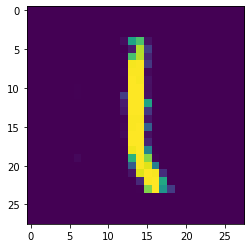

In [ ]:
dLoss = []
gLoss = []
train(20, 128)

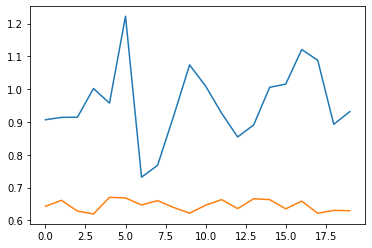

In [ ]:
plt.plot(gLoss, label="generator loss")
plt.plot(dLoss, label="discriminator loss")
plt.show()

### Анализ полученных результатов

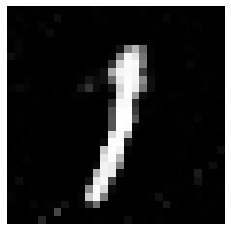

In [ ]:
generator.load_weights("/content/generator.h5")

result = generator.predict(np.random.normal(0,1, size=(1,RANDOM_SIZE)))
plt.imshow(result.reshape(28,28), cmap='gray')
plt.axis("off")
plt.show()

# DCGAN

In [3]:
latent_dim = 128 

generator = Sequential()
generator.add(L.Input(shape=(latent_dim,)))
generator.add(L.Dense(8*8*128))
generator.add(L.Reshape((8, 8, 128)))
generator.add(L.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"))

In [4]:
discriminator = Sequential()
discriminator.add(L.Input(shape=(64, 64, 3)))
discriminator.add(L.Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(L.LeakyReLU(alpha=0.2)) 
discriminator.add(L.Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(L.LeakyReLU(alpha=0.2)) 
discriminator.add(L.Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(L.LeakyReLU(alpha=0.2))   
discriminator.add(L.Flatten())   
discriminator.add(L.Dropout(0.2))   
discriminator.add(L.Dense(1, activation="sigmoid"))   

In [5]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
opt_gen = tf.keras.optimizers.Adam(1e-4)
opt_disc = tf.keras.optimizers.Adam(1e-4)

In [6]:
def train(epochs=10):
  for epoch in range(1, epochs+1):
    print("-"*10, "Epoch: {}".format(epoch), "-"*10)

    for idx, real in enumerate(tqdm(dataset)):
      batch_size = real.shape[0]
      noise = tf.random.normal(shape=(batch_size, latent_dim))
      fake = generator(noise)

      # обучение дискриминатора
      with tf.GradientTape() as disc_tape:
        loss_disc_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
        loss_disc_fake = loss_fn(tf.zeros((batch_size, 1)), discriminator(fake))
        loss_disc = (loss_disc_real + loss_disc_fake)/2

      grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
      opt_disc.apply_gradients(
          zip(grads, discriminator.trainable_weights)
      )


      # обучение генератора
      with tf.GradientTape() as gen_tape:
        fake = generator(noise)
        output = discriminator(fake)
        loss_gen = loss_fn(tf.ones((batch_size, 1)), output)

      grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
      opt_gen.apply_gradients(
          zip(grads, generator.trainable_weights)
      )

    # оценка ошибок и периодическое сохранение картинок и весов
    gLoss.append(loss_gen)
    dLoss.append(loss_disc)
    print("gloss {}, dloss {}".format(loss_gen, loss_disc))
    img = tf.keras.preprocessing.image.array_to_img(fake[0])
    img.save(f"img{epoch}.png")
    discriminator.save(f"./discriminator{epoch}.h5")
    generator.save(f"./generator{epoch}.h5")

# DCGAN для фото знаменитостей

In [8]:
import os
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
).map(lambda x: x/255.0)

Found 202599 files belonging to 1 classes.


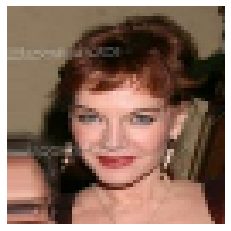

In [8]:
#пример изображения из датасета
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [11]:
dLoss = []
gLoss = []
train(100)

---------- Epoch: 1 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [19:14<00:00,  5.48it/s]

gloss 0.6898296475410461, dloss 0.7449899315834045


---------- Epoch: 2 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:42<00:00,  5.64it/s]

gloss 1.2728697061538696, dloss 0.5832660794258118


---------- Epoch: 3 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:06<00:00,  5.83it/s]

gloss 0.8983195424079895, dloss 0.624458909034729


---------- Epoch: 4 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:54<00:00,  5.89it/s]

gloss 0.9105055928230286, dloss 0.6277941465377808


---------- Epoch: 5 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:53<00:00,  5.90it/s]

gloss 0.8363814949989319, dloss 0.7412712574005127


---------- Epoch: 6 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 0.8067313432693481, dloss 0.8512560129165649


---------- Epoch: 7 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:15<00:00,  5.78it/s]

gloss 0.8190969824790955, dloss 0.6797594428062439


---------- Epoch: 8 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 0.7766858339309692, dloss 0.6943111419677734


---------- Epoch: 9 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 1.0311836004257202, dloss 0.6332850456237793


---------- Epoch: 10 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 0.6171928644180298, dloss 1.0670766830444336


---------- Epoch: 11 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 0.7685513496398926, dloss 0.6441905498504639


---------- Epoch: 12 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 0.8224619030952454, dloss 0.6271357536315918


---------- Epoch: 13 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:50<00:00,  5.91it/s]

gloss 0.8704687356948853, dloss 0.7086780071258545


---------- Epoch: 14 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 0.9370875954627991, dloss 0.6332870721817017


---------- Epoch: 15 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 0.7217381596565247, dloss 0.6947417259216309


---------- Epoch: 16 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 1.1612777709960938, dloss 0.4559386372566223


---------- Epoch: 17 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 0.9665647149085999, dloss 0.8528317809104919


---------- Epoch: 18 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 0.955995500087738, dloss 0.5670208930969238


---------- Epoch: 19 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 0.641520082950592, dloss 0.826604962348938


---------- Epoch: 20 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 1.0633257627487183, dloss 0.6037563681602478


---------- Epoch: 21 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 0.712447464466095, dloss 0.8051375150680542


---------- Epoch: 22 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.91it/s]

gloss 1.0655949115753174, dloss 0.5127047300338745


---------- Epoch: 23 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.91it/s]

gloss 1.1142712831497192, dloss 0.5796204805374146


---------- Epoch: 24 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.91it/s]

gloss 0.805442750453949, dloss 0.6691330075263977


---------- Epoch: 25 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:53<00:00,  5.90it/s]

gloss 1.1348716020584106, dloss 0.6411557793617249


---------- Epoch: 26 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:53<00:00,  5.90it/s]

gloss 0.9252327084541321, dloss 0.5853149890899658


---------- Epoch: 27 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 0.9877672791481018, dloss 0.6372597217559814


---------- Epoch: 28 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:20<00:00,  5.76it/s]

gloss 1.2039822340011597, dloss 0.7264171242713928


---------- Epoch: 29 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:23<00:00,  5.74it/s]

gloss 1.1572539806365967, dloss 0.6900225877761841


---------- Epoch: 30 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:22<00:00,  5.74it/s]

gloss 0.7906931042671204, dloss 0.7900234460830688


---------- Epoch: 31 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:22<00:00,  5.74it/s]

gloss 1.5502960681915283, dloss 0.5396350622177124


---------- Epoch: 32 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:22<00:00,  5.74it/s]

gloss 1.116727590560913, dloss 0.7053307890892029


---------- Epoch: 33 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:24<00:00,  5.73it/s]

gloss 1.1264369487762451, dloss 0.6059023141860962


---------- Epoch: 34 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:24<00:00,  5.73it/s]

gloss 1.1240967512130737, dloss 0.5617337226867676


---------- Epoch: 35 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:23<00:00,  5.74it/s]

gloss 1.0227590799331665, dloss 0.5199673175811768


---------- Epoch: 36 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:23<00:00,  5.74it/s]

gloss 0.9946315884590149, dloss 0.5942966938018799


---------- Epoch: 37 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:32<00:00,  5.69it/s]

gloss 1.1661654710769653, dloss 0.6246539354324341


---------- Epoch: 38 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:39<00:00,  5.66it/s]

gloss 0.9858868718147278, dloss 0.48098456859588623


---------- Epoch: 39 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:27<00:00,  5.72it/s]

gloss 2.1827378273010254, dloss 0.5413585901260376


---------- Epoch: 40 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:28<00:00,  5.71it/s]

gloss 0.9437642693519592, dloss 0.6980589628219604


---------- Epoch: 41 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:23<00:00,  5.74it/s]

gloss 1.1158335208892822, dloss 0.5846884250640869


---------- Epoch: 42 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:25<00:00,  5.73it/s]

gloss 2.1218631267547607, dloss 0.623599648475647


---------- Epoch: 43 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:29<00:00,  5.71it/s]

gloss 0.9038092494010925, dloss 0.546242892742157


---------- Epoch: 44 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:33<00:00,  5.69it/s]

gloss 0.8868640661239624, dloss 0.725684404373169


---------- Epoch: 45 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:35<00:00,  5.68it/s]

gloss 0.800122857093811, dloss 0.6370905637741089


---------- Epoch: 46 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:31<00:00,  5.70it/s]

gloss 1.1455705165863037, dloss 0.47495323419570923


---------- Epoch: 47 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:39<00:00,  5.66it/s]

gloss 1.1425672769546509, dloss 0.6717215776443481


---------- Epoch: 48 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:37<00:00,  5.66it/s]

gloss 1.1814448833465576, dloss 0.7083353996276855


---------- Epoch: 49 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:26<00:00,  5.72it/s]

gloss 1.161934733390808, dloss 0.47876521944999695


---------- Epoch: 50 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:30<00:00,  5.70it/s]

gloss 1.0643643140792847, dloss 0.5070018768310547


---------- Epoch: 51 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:19<00:00,  5.76it/s]

gloss 1.8193604946136475, dloss 0.4250715970993042


---------- Epoch: 52 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:30<00:00,  5.70it/s]

gloss 0.7539171576499939, dloss 0.6555199027061462


---------- Epoch: 53 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:29<00:00,  5.71it/s]

gloss 1.179070234298706, dloss 0.4716683030128479


---------- Epoch: 54 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:26<00:00,  5.72it/s]

gloss 1.1956247091293335, dloss 0.6197032928466797


---------- Epoch: 55 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:22<00:00,  5.74it/s]

gloss 1.0160033702850342, dloss 0.6305844783782959


---------- Epoch: 56 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:32<00:00,  5.69it/s]

gloss 1.0746080875396729, dloss 0.7425470352172852


---------- Epoch: 57 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:28<00:00,  5.71it/s]

gloss 1.1039799451828003, dloss 0.551466703414917


---------- Epoch: 58 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:39<00:00,  5.66it/s]

gloss 1.0288258790969849, dloss 0.6412658095359802


---------- Epoch: 59 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:25<00:00,  5.73it/s]

gloss 1.0374220609664917, dloss 0.6670752763748169


---------- Epoch: 60 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:28<00:00,  5.71it/s]

gloss 0.9237920045852661, dloss 0.4747200906276703


---------- Epoch: 61 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:40<00:00,  5.65it/s]

gloss 1.0714236497879028, dloss 0.4960436224937439


---------- Epoch: 62 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:27<00:00,  5.72it/s]

gloss 1.1078784465789795, dloss 0.5491831302642822


---------- Epoch: 63 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:27<00:00,  5.72it/s]

gloss 0.7470959424972534, dloss 0.6255328059196472


---------- Epoch: 64 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:26<00:00,  5.72it/s]

gloss 1.341746211051941, dloss 0.4923497140407562


---------- Epoch: 65 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:48<00:00,  5.61it/s]

gloss 0.7012171149253845, dloss 0.6023716926574707


---------- Epoch: 66 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [20:38<00:00,  5.11it/s]

gloss 1.1123381853103638, dloss 0.8954454660415649


---------- Epoch: 67 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [20:28<00:00,  5.15it/s]

gloss 1.3806126117706299, dloss 0.45012515783309937


---------- Epoch: 68 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:46<00:00,  5.62it/s]

gloss 1.2663987874984741, dloss 0.6717215776443481


---------- Epoch: 69 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:28<00:00,  5.71it/s]

gloss 0.9487018585205078, dloss 0.7527453303337097


---------- Epoch: 70 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:28<00:00,  5.71it/s]

gloss 0.878874659538269, dloss 0.6187766790390015


---------- Epoch: 71 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:32<00:00,  5.69it/s]

gloss 0.8853005766868591, dloss 0.5645855665206909


---------- Epoch: 72 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:32<00:00,  5.69it/s]

gloss 0.7029451727867126, dloss 0.6550321578979492


---------- Epoch: 73 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:34<00:00,  5.68it/s]

gloss 1.2115927934646606, dloss 0.6440213322639465


---------- Epoch: 74 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:29<00:00,  5.71it/s]

gloss 1.2781790494918823, dloss 0.38565295934677124


---------- Epoch: 75 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:35<00:00,  5.68it/s]

gloss 1.1411436796188354, dloss 0.46727612614631653


---------- Epoch: 76 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:26<00:00,  5.72it/s]

gloss 0.9854688048362732, dloss 0.90125572681427


---------- Epoch: 77 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [18:12<00:00,  5.79it/s]

gloss 1.1273144483566284, dloss 0.563474178314209


---------- Epoch: 78 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 1.202901005744934, dloss 0.6428889632225037


---------- Epoch: 79 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.91it/s]

gloss 0.9156575798988342, dloss 0.6470699906349182


---------- Epoch: 80 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.91it/s]

gloss 1.099648118019104, dloss 0.5380088686943054


---------- Epoch: 81 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 1.1272228956222534, dloss 0.5153329968452454


---------- Epoch: 82 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:54<00:00,  5.89it/s]

gloss 1.1957988739013672, dloss 0.46402662992477417


---------- Epoch: 83 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 1.0720767974853516, dloss 0.6362005472183228


---------- Epoch: 84 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.91it/s]

gloss 1.3558954000473022, dloss 0.4549992084503174


---------- Epoch: 85 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 1.0105229616165161, dloss 0.643578052520752


---------- Epoch: 86 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 0.8177690505981445, dloss 0.733522891998291


---------- Epoch: 87 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:50<00:00,  5.91it/s]

gloss 1.0792945623397827, dloss 0.44181644916534424


---------- Epoch: 88 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:51<00:00,  5.91it/s]

gloss 1.0584338903427124, dloss 0.4743875563144684


---------- Epoch: 89 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:49<00:00,  5.92it/s]

gloss 1.4794337749481201, dloss 0.3949396014213562


---------- Epoch: 90 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:50<00:00,  5.91it/s]

gloss 1.3986585140228271, dloss 0.38059118390083313


---------- Epoch: 91 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:50<00:00,  5.91it/s]

gloss 1.1216728687286377, dloss 0.6027829647064209


---------- Epoch: 92 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 1.0250027179718018, dloss 0.3487190008163452


---------- Epoch: 93 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 0.9894531965255737, dloss 0.6401047706604004


---------- Epoch: 94 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:53<00:00,  5.90it/s]

gloss 1.2207683324813843, dloss 0.5010008811950684


---------- Epoch: 95 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.91it/s]

gloss 1.5810915231704712, dloss 0.6712983250617981


---------- Epoch: 96 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 1.3830498456954956, dloss 0.3000307083129883


---------- Epoch: 97 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 1.2878824472427368, dloss 0.7675361633300781


---------- Epoch: 98 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.90it/s]

gloss 1.1243326663970947, dloss 0.6289792060852051


---------- Epoch: 99 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:53<00:00,  5.90it/s]

gloss 1.1754286289215088, dloss 0.5729515552520752


---------- Epoch: 100 ----------


100%|██████████████████████████████████████████████████████████████████████████████| 6332/6332 [17:52<00:00,  5.91it/s]

gloss 1.0969139337539673, dloss 0.5010678768157959


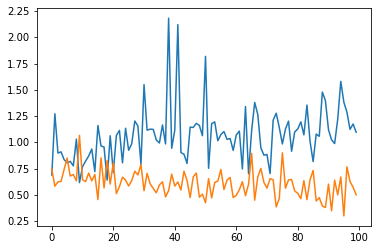

In [12]:
plt.plot(gLoss, label="generator loss")
plt.plot(dLoss, label="discriminator loss")
plt.show()

### Анализ полученных результатов

<function matplotlib.pyplot.show(close=None, block=None)>

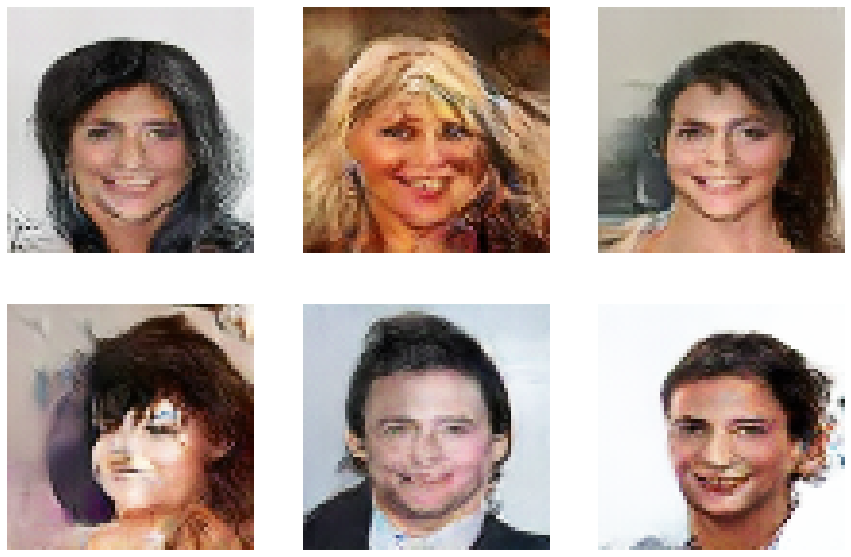

In [16]:
imgNum = 6
generator.load_weights("./generator100.h5")

imgs = [generator(tf.random.normal(shape=(32, latent_dim))) for i in range(imgNum)]

f, axarr = plt.subplots(2,len(imgs)//2, figsize=(imgNum * 2.5, 10))
for i in range(len(imgs)): 
  axarr[i%2,i//2].imshow((imgs[i].numpy() * 255).astype("int32")[0])
  axarr[i%2,i//2].axis('off')
plt.show